In [4]:
import matplotlib.pyplot as plt
fontsize = 8
fontstyle = {
    "pdf.fonttype": 42, # type 3 pdf fonts
    "mathtext.default": 'regular', # italic math
    'mathtext.fontset': 'cm',
    'font.family' : 'STIXGeneral',
    "text.latex.preamble":
        r'\usepackage{upgreek}',
    "text.usetex": True, # latex-based math
    # sans-serif Helvetica font
    #"text.latex.preamble":
    #    r'\usepackage{helvet} \usepackage{sansmath} \sansmath',
    #"font.family": "sans-serif",
    # font sizes
    "axes.labelsize": fontsize,
    'axes.titlesize': fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    'xtick.direction': "inout",
    'xtick.top': True,
    'xtick.major.size': 4,
    'xtick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    "ytick.labelsize": fontsize,
    'ytick.direction': "inout",
    'ytick.right': True,
    'ytick.major.size': 4,
    'ytick.major.width': 0.5,
    'ytick.minor.width': 0.5,
    "axes.linewidth": 0.5,
}

plt.rcParams.update(fontstyle)

letters_lower = [r"$\mathrm{\bf{%s}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"]
letters_round = [r"$\mathrm{\bf{(%s)}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"]
letters_upper = [r"$\bf{%s}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz".upper()]
letters_map = {"round": letters_round, "upper": letters_upper, "lower":letters_lower}  
def lettering(ax, x, y, num, color="k", mode="round", **kwargs):    
    letters = letters_map[mode]    
    ax.text(x, y, letters[num], weight="bold", transform=ax.transAxes,            
            horizontalalignment="center", verticalalignment="center", color=color, **kwargs)

cmap = plt.colormaps['tab20']

In [5]:
import analysis
import numpy as np
import matplotlib.pyplot as plt
# ("telescope", "Telescope"), 
names = [("microphone", "Sagnac"), ("sagnac", "Sagnac"), ("split beam", "SplitBeam")]
phis = ["phi" + str(int(np.append(82, np.linspace(145, 160, 16))[i])) + ".tdms" for i in range(len(np.append(82, np.linspace(145, 160, 16))))]
systems = np.array([])
for n in names:
    systems = np.append(systems, analysis.System(n[0], ["../data/20230801/" + n[1] + "/iter_0.tdms"] + ["../data/20230801/" + n[1] + "/MinDetect/" + i for i in phis], phis = [int(p[3:-5]) for p in phis]))

def Daici(freq, dist = 0.1, T = 20, n = 1.0003):
    from brownian import get_sound_speed
    from scipy.special import kv
    a = get_sound_speed(T, 0.5, 99e3)
    c = dist / a
    s = c * freq * 2j * np.pi
    return s * kv(1, s) * np.exp(s)

def mic_correct(c, taps = 151, lfs = 0.68e-3) -> (list, list):
    """
    mic_correct uses the impulse response function of the microphone
    to correct the signal using a digital filter (scipy.signal.filtfilt).
    :param c: collection object of TDMS object.
    :param lfs: lfs of microphone (provided by manufacturer).
    :return: list of times of the collection data and 
             list of corrected signal of the collection data.
    """
    import acoustic_entrainment
    import scipy.signal as sig
    import numpy as np
    # creating array of gain values using acoustic_entrainment.dBs_orig
    gains = lfs * 10 ** (acoustic_entrainment.dBs_orig / 20)
    # making the filter using sig.firwin2
    # 1st value provided is the number of taps for the filter
    # 2nd value is the range of frequencies for the filter -- specified in acoustic_entrainment
    # 3rd value is the array of gains created above
    # 4th value is the maximum frequency times two
    # this filter is also converted into a minimum phase filter (sig.minimum_phase)
    # lastly, the filter is translated into its inverse using ifft and 1 / fft
    filter = np.real(np.fft.ifft(1 / np.fft.fft(sig.minimum_phase(sig.firwin2(taps, np.r_[0, acoustic_entrainment.fs_orig], np.r_[0, gains], fs = 2 * acoustic_entrainment.fs_orig[-1])))))
    return c.t, sig.filtfilt(filter, [1], c.x)

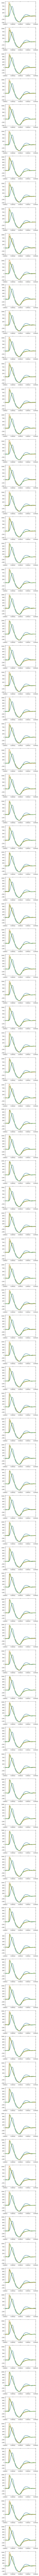

In [6]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
ind = 0
peak = [[], [], []]
LER_t = [[], [], []]
fig, ax = plt.subplots(len(systems[0].get_data()[ind].collection) - 1, 1)

systems[0].set_data(ind = ind) # set mic to data ind = 0
systems[1].set_data(ind = ind) # sagnac, data ind = 0
systems[2].set_data(ind = ind) # split, data ind = 0
cutoffs = [2e5, 2e6, 2e6]
b_cutoffs = [8 * 2e5, 2 * 2e6, 2 * 2e6]
cals = [[], []]
tau = [[], []]
for i, s in enumerate(systems):
    if i == 0:
        systems[i].get_data()[ind].apply("detrend", mode = "constant", inplace = True)
        systems[i].get_data()[ind].apply("lowpass", cutoff = cutoffs[i], inplace = True)
        systems[i].get_data()[ind].apply("bin_average", Npts = int(systems[i].get_data()[ind].r / b_cutoffs[i]), inplace = True)
    for col_i in range(1, len(s.get_data()[ind].collection)):
        if i == 0:
            s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x = mic_correct(s.get_data()[ind].collection[col_i])
            ax[col_i - 1].set_xlim([4.1e-4, 4.5e-4])
            ax[col_i - 1].plot(s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x)
        else:
            s.set_data(ind = ind, tmin = 4.3e-4, tmax = 5e-4)
            s.get_data()[ind].apply("shift", tau = -4.3e-4, inplace = True)
            s.get_data()[ind].apply("correct", response = Daici, recollect = True)
            s.get_data()[ind].apply("detrend", mode = "constant", inplace = True)
            s.get_data()[ind].apply("lowpass", cutoff = cutoffs[i], inplace = True)
            s.get_data()[ind].apply("bin_average", Npts = int(systems[i].get_data()[ind].r / b_cutoffs[i]), inplace = True)
            tau[i - 1].append(analysis.mic_tau_shift(systems[i], systems[0], ind, col_i))
            s.get_data()[ind].apply("shift", tau = -tau[i - 1][-1], inplace = True)
            cals[i - 1].append(analysis.calc_cal_factor(s.get_data()[ind].collection[col_i], systems[0].get_data()[ind].collection[col_i], i))
            s.get_data()[ind].apply("calibrate", cal = cals[i - 1][-1], inplace = True)
            # if i != 2:
            ax[col_i - 1].plot(s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x)
        peak[i].append(np.max(s.get_data()[ind].collection[col_i].time_gate(tmin = 4e-4, tmax = 4.5e-4)[1]))
        s_idx = np.where(s.get_data()[ind].collection[col_i].x == np.max(s.get_data()[ind].collection[col_i].time_gate(tmin = 3.5e-4, tmax = 5e-4)[1][0]))[0][0]
        f_idx = np.where(s.get_data()[ind].collection[col_i].x == peak[i][-1])[0][0]
        ten_idx = np.where(s.get_data()[ind].collection[col_i].x == find_nearest(s.get_data()[ind].collection[col_i].x[s_idx:f_idx], peak[i][-1] * 0.1))[0][0]
        ninety_idx = np.where(s.get_data()[ind].collection[col_i].x == find_nearest(s.get_data()[ind].collection[col_i].x[s_idx:f_idx], peak[i][-1] * 0.9))[0][0]
        LER_t[i].append(s.get_data()[ind].collection[col_i].t[ninety_idx] - s.get_data()[ind].collection[col_i].t[ten_idx])
fig.set_size_inches(3.375, 288)
plt.show()
systems[0].set_data(ind = ind) # set mic to data ind = 0
systems[1].set_data(ind = ind) # sagnac, data ind = 0
systems[2].set_data(ind = ind) # split, data ind = 0

Sagnac Calibration Factors:
Average Calibration Factor:		2.41e-05 +/- 7.56e-07
Error Percentage:			3.14%
[2.43190963e-05 2.48187667e-05 2.48777424e-05 2.46573670e-05
 2.35691407e-05 2.37962174e-05 2.38885441e-05 2.33018915e-05
 2.38577208e-05 2.38184476e-05 2.32683311e-05 2.55025926e-05
 2.38976486e-05 2.39848697e-05 2.38594304e-05 2.36643811e-05
 2.35125608e-05 2.32086183e-05 2.40818505e-05 2.39755268e-05
 2.43604789e-05 2.44028866e-05 2.36472898e-05 2.41647224e-05
 2.39939069e-05 2.36010839e-05 2.30612387e-05 2.38295974e-05
 2.31928909e-05 2.25810579e-05 2.32152195e-05 2.36911871e-05
 2.36567665e-05 2.49569312e-05 2.42980900e-05 2.47868117e-05
 2.45061387e-05 2.45368449e-05 2.39662777e-05 2.37438668e-05
 2.37804008e-05 2.31828018e-05 2.27374805e-05 2.49709442e-05
 2.39344809e-05 2.44650445e-05 2.34767535e-05 2.44089811e-05
 2.36316826e-05 2.36823514e-05 2.47647919e-05 2.44882579e-05
 2.41440899e-05 2.46224937e-05 2.44321263e-05 2.47351415e-05
 2.46631992e-05 2.58501717e-05 2.48645398

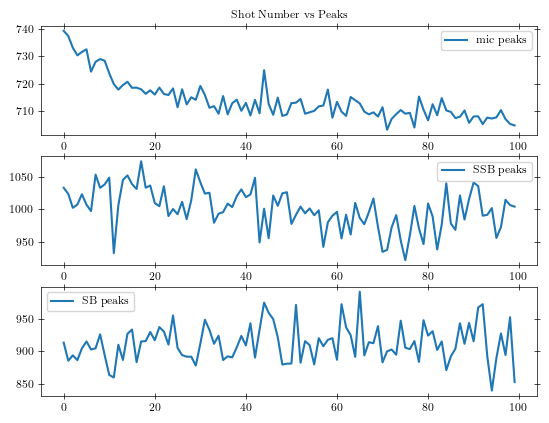

In [7]:
print("\033[4m" + "Sagnac Calibration Factors:" + "\033[0m")
print("Average Calibration Factor:\t\t%.2e +/- %.2e" % (np.mean(1 / np.array(cals[0])), np.std(1 / np.array(cals[0]))))
print("Error Percentage:\t\t\t%1.2f%%" % (100 * np.std(1 / np.array(cals[0])) / np.mean(1 / np.array(cals[0]))))
print(1 / np.array(cals[0]))
print("Sagnac Peak Values")
print(np.array(peak[1]))
print("Sagnac LER Times")
print("Average LER Times:\t\t%.2e +/- %.2e" % (np.mean(LER_t[1]), np.std(LER_t[1])))
print(np.array(LER_t[1]))

print("\n\n=================================================================================")
print("=================================================================================")

print("\n\n\033[4m" + "SB Calibration Factors" + "\033[0m")
print("Average Calibration Factor:\t\t%.2e +/- %.2e" % (np.mean(1 / np.array(cals[1])), np.std(1 / np.array(cals[1]))))
print("Error Percentage:\t\t\t%1.2f%%" % (100 * np.std(1 / np.array(cals[1])) / np.mean(1 / np.array(cals[1]))))
print(1 / np.array(cals[1]))
print("SB Peak Values")
print(np.array(peak[2]))
print("SB LER Times")
print("Average LER Times:\t\t%.2e +/- %.2e" % (np.mean(LER_t[2]), np.std(LER_t[2])))
print(np.array(LER_t[2]))

fig, ax = plt.subplots(3, 1)
ax[0].plot(peak[0], label = "mic peaks")
ax[1].plot(peak[1], label = "SSB peaks")
ax[2].plot(peak[2], label = "SB peaks")
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title("Shot Number vs Peaks")
# fig.savefig("Peaks.png")
plt.show()

In [21]:
ind = 0
col_i = 3

systems[0].set_data(ind = ind)
print(np.max(systems[0].get_data()[ind].collection[col_i].x))
systems[0].get_data()[ind].apply("detrend", mode = "constant", inplace = True)
systems[0].get_data()[ind].apply("lowpass", cutoff = 2e5, inplace = True)
systems[0].get_data()[ind].apply("bin_average", Npts = int(systems[0].get_data()[ind].r / (8 * 2e5)), inplace = True)
print(np.max(systems[0].get_data()[ind].collection[col_i].x))
systems[0].get_data()[ind].collection[col_i].t, systems[0].get_data()[ind].collection[col_i].x = mic_correct(systems[0].get_data()[ind].collection[col_i])
print(np.max(systems[0].get_data()[ind].collection[col_i].x))

systems[0].set_data(ind = ind)
print(np.max(systems[0].get_data()[ind].collection[col_i].x))
systems[0].get_data()[ind].apply("detrend", mode = "constant", inplace = True)
systems[0].get_data()[ind].apply("lowpass", cutoff = 2e5, inplace = True)
systems[0].get_data()[ind].apply("bin_average", Npts = int(systems[0].get_data()[ind].r / (8 * 2e5)), inplace = True)
print(np.max(systems[0].get_data()[ind].collection[col_i].x))
systems[0].get_data()[ind].collection[col_i].t, systems[0].get_data()[ind].collection[col_i].x = mic_correct(systems[0].get_data()[ind].collection[col_i])
print(np.max(systems[0].get_data()[ind].collection[col_i].x))

0.53143310546875
0.49441889718110005
733.147398019803
0.53143310546875
0.49441889718110005
733.147398019803


In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
ind = 0
peak = [[], [], []]
LER_t = [[], [], []]
fig, ax = plt.subplots(len(systems[0].get_data()[ind].collection) - 1, 1)

systems[0].set_data(ind = ind) # set mic to data ind = 0
systems[1].set_data(ind = ind) # sagnac, data ind = 0
systems[2].set_data(ind = ind) # split, data ind = 0
cutoffs = [2e5, 2e6, 2e6]
b_cutoffs = [8 * 2e5, 2 * 2e6, 2 * 2e6]
cals = [[], []]
tau = [[], []]
for i, s in enumerate(systems):
    if i == 0:
        systems[i].get_data()[ind].apply("detrend", mode = "constant", inplace = True)
        systems[i].get_data()[ind].apply("lowpass", cutoff = cutoffs[i], inplace = True)
        systems[i].get_data()[ind].apply("bin_average", Npts = int(systems[i].get_data()[ind].r / b_cutoffs[i]), inplace = True)
    for col_i in range(1, len(s.get_data()[ind].collection)):
        if i == 0:
            s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x = mic_correct(s.get_data()[ind].collection[col_i])
            ax[col_i - 1].set_xlim([4.1e-4, 4.5e-4])
            ax[col_i - 1].plot(s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x)
        else:
            s.set_data(ind = ind, tmin = 4.3e-4, tmax = 5e-4)
            s.get_data()[ind].apply("shift", tau = -4.3e-4, inplace = True)
            # s.get_data()[ind].apply("correct", response = Daici, recollect = True)
            s.get_data()[ind].apply("detrend", mode = "constant", inplace = True)
            s.get_data()[ind].apply("lowpass", cutoff = cutoffs[i], inplace = True)
            s.get_data()[ind].apply("bin_average", Npts = int(systems[i].get_data()[ind].r / b_cutoffs[i]), inplace = True)
            tau[i - 1].append(analysis.mic_tau_shift(systems[i], systems[0], ind, col_i))
            s.get_data()[ind].apply("shift", tau = -tau[i - 1][-1], inplace = True)
            cals[i - 1].append(analysis.calc_cal_factor(s.get_data()[ind].collection[col_i], systems[0].get_data()[ind].collection[col_i], i))
            s.get_data()[ind].apply("calibrate", cal = cals[i - 1][-1], inplace = True)
            # if i != 2:
            ax[col_i - 1].plot(s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x)
        peak[i].append(np.max(s.get_data()[ind].collection[col_i].time_gate(tmin = 4e-4, tmax = 4.5e-4)[1]))
        s_idx = np.where(s.get_data()[ind].collection[col_i].x == np.max(s.get_data()[ind].collection[col_i].time_gate(tmin = 3.5e-4, tmax = 5e-4)[1][0]))[0][0]
        f_idx = np.where(s.get_data()[ind].collection[col_i].x == peak[i][-1])[0][0]
        ten_idx = np.where(s.get_data()[ind].collection[col_i].x == find_nearest(s.get_data()[ind].collection[col_i].x[s_idx:f_idx], peak[i][-1] * 0.1))[0][0]
        ninety_idx = np.where(s.get_data()[ind].collection[col_i].x == find_nearest(s.get_data()[ind].collection[col_i].x[s_idx:f_idx], peak[i][-1] * 0.9))[0][0]
        LER_t[i].append(s.get_data()[ind].collection[col_i].t[ninety_idx] - s.get_data()[ind].collection[col_i].t[ten_idx])
fig.set_size_inches(3.375, 288)
fig.savefig("allshotsadjusted.png")
plt.show()
systems[0].set_data(ind = ind) # set mic to data ind = 0
systems[1].set_data(ind = ind) # sagnac, data ind = 0
systems[2].set_data(ind = ind) # split, data ind = 0

Sagnac Calibration Factors:
Average Calibration Factor:		2.85e-04 +/- 7.61e-06
Error Percentage:			2.67%
[0.00028306 0.00029477 0.00028635 0.00027898 0.00028562 0.00028266
 0.00027645 0.00028424 0.00028239 0.00028373 0.00027539 0.0003011
 0.00028008 0.00029085 0.00028427 0.00028232 0.00027389 0.00028457
 0.00029662 0.00028947 0.00029234 0.00028937 0.00028449 0.00028151
 0.00028939 0.00027548 0.00028767 0.00027728 0.00028478 0.00027335
 0.00026645 0.00028137 0.00028507 0.00028846 0.00028264 0.0002935
 0.00028857 0.00028516 0.00028114 0.0002921  0.00028174 0.00026966
 0.0002796  0.0002953  0.00027869 0.00027582 0.00028083 0.0002899
 0.00027505 0.00029202 0.00028413 0.00028908 0.00028829 0.0002836
 0.00028938 0.00029047 0.00029289 0.00029277 0.00028963 0.00029103
 0.00028689 0.00028919 0.00029741 0.00029303 0.00028693 0.00030054
 0.00029364 0.00028781 0.00029009 0.00028751 0.00030428 0.00028238
 0.00029112 0.00028255 0.00028949 0.00029548 0.00030162 0.0002798
 0.00028848 0.00029438 0.0002

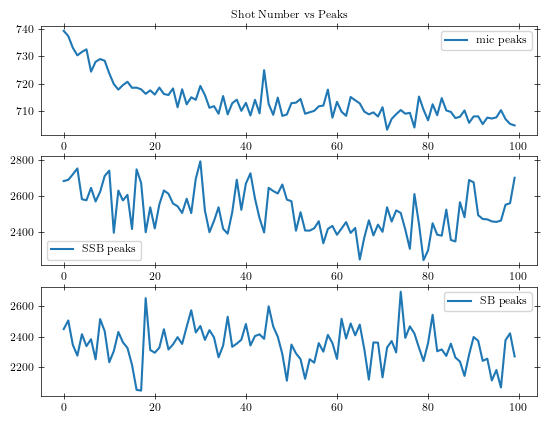

In [23]:
print("\033[4m" + "Sagnac Calibration Factors:" + "\033[0m")
print("Average Calibration Factor:\t\t%.2e +/- %.2e" % (np.mean(1 / np.array(cals[0])), np.std(1 / np.array(cals[0]))))
print("Error Percentage:\t\t\t%1.2f%%" % (100 * np.std(1 / np.array(cals[0])) / np.mean(1 / np.array(cals[0]))))
print(1 / np.array(cals[0]))
print("Sagnac Peak Values")
print(np.array(peak[1]))
print("Sagnac LER Times")
print("Average LER Times:\t\t%.2e +/- %.2e" % (np.mean(LER_t[1]), np.std(LER_t[1])))
print(np.array(LER_t[1]))

print("\n\n=================================================================================")
print("=================================================================================")

print("\n\n\033[4m" + "SB Calibration Factors" + "\033[0m")
print("Average Calibration Factor:\t\t%.2e +/- %.2e" % (np.mean(1 / np.array(cals[1])), np.std(1 / np.array(cals[1]))))
print("Error Percentage:\t\t\t%1.2f%%" % (100 * np.std(1 / np.array(cals[1])) / np.mean(1 / np.array(cals[1]))))
print(1 / np.array(cals[1]))
print("SB Peak Values")
print(np.array(peak[2]))
print("SB LER Times")
print("Average LER Times:\t\t%.2e +/- %.2e" % (np.mean(LER_t[2]), np.std(LER_t[2])))
print(np.array(LER_t[2]))

fig, ax = plt.subplots(3, 1)
ax[0].plot(peak[0], label = "mic peaks")
ax[1].plot(peak[1], label = "SSB peaks")
ax[2].plot(peak[2], label = "SB peaks")
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_title("Shot Number vs Peaks")
# fig.savefig("Peaks.png")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


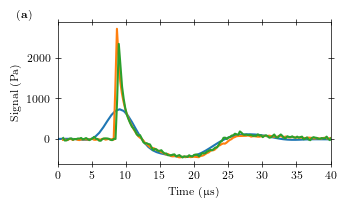

In [26]:
fig, ax = plt.subplots(1, 1)

ind = 0
col_i = 3
l_cutoff = 2e6
m_cutoff = 2e5
systems[0].set_data(ind = ind) # set mic to data ind = 0
systems[1].set_data(ind = ind) # sagnac, data ind = 0
systems[2].set_data(ind = ind) # split, data ind = 0

for i, s in enumerate(systems):
    if i == 0:
        s.get_data()[ind].apply("detrend", mode = "constant", inplace = True)
        s.get_data()[ind].apply("lowpass", cutoff = m_cutoff, inplace = True)
        s.get_data()[ind].apply("bin_average", Npts = int(systems[0].get_data()[ind].r / (8 * m_cutoff)), inplace = True)
        s.get_data()[ind].collection[col_i].t, s.get_data()[ind].collection[col_i].x = mic_correct(s.get_data()[ind].collection[col_i])
        ax.plot(s.get_data()[ind].collection[col_i].t * 1e6 - 410, s.get_data()[ind].collection[col_i].x)
    else:
        s.set_data(ind = ind, tmin = 4.3e-4, tmax = 5e-4)
        s.get_data()[ind].apply("shift", tau = -4.3e-4, inplace = True)
        s.get_data()[ind].apply("detrend", mode = "constant", inplace = True)
        s.get_data()[ind].apply("lowpass", cutoff = l_cutoff, inplace = True)
        s.get_data()[ind].apply("bin_average", Npts = int(systems[i].get_data()[ind].r / (2 * l_cutoff)), inplace = True)
        tau = analysis.mic_tau_shift(systems[i], systems[0], ind, col_i)
        s.get_data()[ind].apply("shift", tau = -tau, inplace = True)
        cal = analysis.calc_cal_factor(s.get_data()[ind].collection[col_i], systems[0].get_data()[ind].collection[col_i], i)
        s.get_data()[ind].apply("calibrate", cal = cals[i - 1][col_i - 1], inplace = True)
        ax.plot(s.get_data()[ind].collection[col_i].t * 1e6 - 410, s.get_data()[ind].collection[col_i].x)
systems[0].set_data(ind = ind) # set mic to data ind = 0
systems[1].set_data(ind = ind) # sagnac, data ind = 0
systems[2].set_data(ind = ind) # split, data ind = 0
# concluding figure (a)

ax.set_xlim(0, 40)
ax.set_xlabel(r"Time ($\upmu$s)")
ax.set_ylabel("Signal (Pa)")
lettering(ax, -0.12, 1.05, 0)
fig.set_size_inches(3.375, 2)
fig.tight_layout(pad = 0.5)
fig.legend(loc = "lower center", frameon = False, ncol = 1, bbox_to_anchor = (0.8, 0.8), handlelength = 0.8, handletextpad = 0.4, columnspacing = 0.8)
fig.savefig("noDaici.png", format = "png")
plt.show()
systems[0].set_data(ind = ind) # set mic to data ind = 0
systems[1].set_data(ind = ind) # sagnac, data ind = 0
systems[2].set_data(ind = ind) # split, data ind = 0